In [195]:
import torch
import numpy as np
import einops
import matplotlib.pyplot as plt

from tqdm import tqdm

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNetBN
from cfollmer.sampler_utils import FollmerSDE

In [196]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [204]:
d = 1.0
sigma2 = 0.1
mus = torch.tensor([
    [d, 0.0],
    [d, d],
    [d, -d],
    [d, 2 * d],
    [d, - 2 * d],
    [2 * d, 0.0],
    [2 * d, d],
    [2 * d, -d],
    [2 * d, 2 * d],
    [2 * d, - 2 * d],
], device=device)

def log_p(x):
    # x : [b, 2]
    # mus : [n, 2]
    
    # I need x - mus : [b, n,]
    dist_to_means = torch.cdist(x, mus)**2
    return torch.logsumexp(-dist_to_means / (2 * sigma2), 1)

In [205]:
mus

tensor([[ 1.,  0.],
        [ 1.,  1.],
        [ 1., -1.],
        [ 1.,  2.],
        [ 1., -2.],
        [ 2.,  0.],
        [ 2.,  1.],
        [ 2., -1.],
        [ 2.,  2.],
        [ 2., -2.]], device='cuda:0')

In [229]:
rng = torch.linspace(-5, 5, 100, device=device)
xx, yy = torch.meshgrid(rng, rng)
coords = torch.dstack([xx, yy])
coords = coords.reshape(-1, 2)
log_ps = log_posterior(coords)
z = log_ps.reshape(100, 100)
z = torch.exp(z)

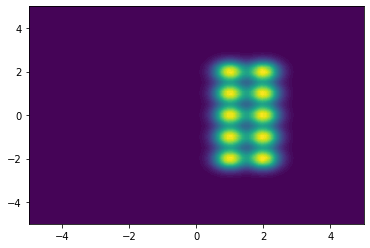

In [231]:
plt.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

In [208]:
def train(gamma, n_iterations, param_batch_size, dt=0.05):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []
    
    for _ in tqdm(range(n_iterations)):
        optimizer.zero_grad()
        
        loss = relative_entropy_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        losses.append(loss.detach().cpu().numpy())
    
    losses = np.array(losses)
    
    return sde, losses

In [235]:
gamma = 2.0
n_iterations = 1000
param_batch_size = 128

In [236]:
sde, losses = train(gamma, n_iterations, param_batch_size, dt=0.05)

  0%|                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.44it/s]


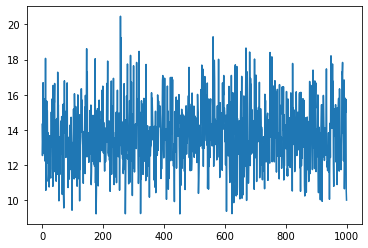

In [237]:
plt.plot(losses)

In [238]:
with torch.no_grad():
    samples = sde.sample(1000, dt=0.01, device=device)
    samples = samples.cpu().numpy()

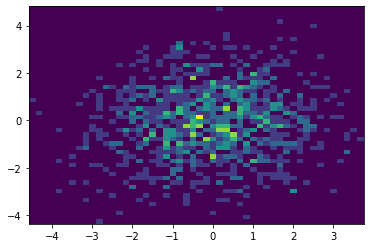

In [239]:
plt.hist2d(samples[:, 0], samples[:, 1], bins=50);